In [8]:
!pip install nltk numpy matplotlib torch tqdm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 77.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 117.5 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install ipdb

In [259]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet2022, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet2022')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [260]:
lema = WordNetLemmatizer()
stopword = set(stopwords.words('english'))

def process_text(text):
    tokens = word_tokenize(text)
    tokens = [lema.lemmatize(token) for token in tokens if token.isalpha() and token not in stopword]
    tokens = [token.lower() for token in tokens]
    return tokens

In [261]:
from nltk.corpus import wordnet as wn
import numpy as np

def build_wordnet_vocab(max_synsets_per_pos=None):
    vocab = set()
    definitions = {}

    poses = ['a', 'r', 's', 'v', 'n']

    for pos in poses:
        for i, synset in enumerate(wn.all_synsets(pos)):
            if max_synsets_per_pos is not None and i >= max_synsets_per_pos:
                break

            word = synset.name().split('.')[0]
            gloss = synset.definition()
            tokens = process_text(gloss)
            if not tokens:
                continue
            definitions[word] = tokens
            vocab.update(tokens + [word])

    # Introduce <UNK> token
    vocab.add('<UNK>')

    word_to_id = {word: idx for idx, word in enumerate(sorted(vocab))}
    id_to_word = {idx: word for word, idx in word_to_id.items()}
    return definitions, word_to_id, id_to_word

definitions, word_to_id, id_to_word = build_wordnet_vocab()

# Initialize embeddings randomly (will later load pre-trained embeddings if available)
vocab_size = len(word_to_id)
embedding_dim = 300  # Define embedding size


In [262]:
vocab_size

96081

{'able': ['usually',
  'followed',
  'necessary',
  'mean',
  'skill',
  'authority',
  'something'],
 'unable': ['usually', 'followed', 'necessary', 'mean', 'skill'],
 'abaxial': ['facing', 'away', 'axis', 'organ', 'organism'],
 'adaxial': ['nearest', 'facing', 'toward', 'axis', 'organ', 'organism'],
 'acroscopic': ['facing', 'side', 'toward', 'apex'],
 'basiscopic': ['facing', 'side', 'toward', 'base'],
 'abducent': ['especially',
  'muscle',
  'drawing',
  'away',
  'midline',
  'body',
  'adjacent',
  'part'],
 'adducent': ['especially',
  'muscle',
  'bringing',
  'together',
  'drawing',
  'toward',
  'midline',
  'body',
  'toward',
  'adjacent',
  'part'],
 'nascent': ['born', 'beginning'],
 'emergent': ['coming', 'existence'],
 'dissilient': ['bursting', 'open', 'force', 'ripe', 'seed', 'vessel'],
 'parturient': ['giving', 'birth'],
 'dying': ['associated', 'process', 'passing', 'life', 'ceasing'],
 'moribund': ['point', 'death', 'breathing', 'last'],
 'last': ['occurring', 't

In [263]:
import random

def generate_wordnet_pairs(definitions, word_to_id):
    pairs = []
    for word, tokens in definitions.items():
        if word not in word_to_id:
            word_id = word_to_id['<UNK>']
        else:
            word_id = word_to_id[word]

        for token in tokens:
            if token in word_to_id:
                token_id = word_to_id[token]
            else:
                token_id = word_to_id['<UNK>']
            pairs.append((word_id, token_id))
    # Remove duplicates
    pairs = list(set(pairs))
    return pairs

wordnet_pairs = generate_wordnet_pairs(definitions, word_to_id)

In [264]:
from sklearn.model_selection import train_test_split

def split_data(pairs, test_size=0.2, val_size=0.1, random_seed=42):
    train_val_pairs, test_pairs = train_test_split(pairs, test_size=test_size, random_state=random_seed)
    train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=val_size, random_state=random_seed)
    return train_pairs, val_pairs, test_pairs


In [265]:
train_pairs, val_pairs, test_pairs = split_data(wordnet_pairs)


In [266]:
def generate_negative_samples(pairs, vocab_size, num_negatives=5, random_seed=42):
    random.seed(random_seed)
    pairs_set = set(pairs)
    negatives = []
    for word_id, context_id in pairs_set:
        for _ in range(num_negatives):
            negative_id = random.randint(0, vocab_size - 1)
            while (word_id, negative_id) in pairs_set or negative_id == context_id:
                negative_id = random.randint(0, vocab_size - 1)
            negatives.append((word_id, negative_id))
    # Remove duplicates
    negatives = list(set(negatives))
    return negatives

In [267]:
train_negatives = generate_negative_samples(train_pairs, vocab_size)
val_negatives = generate_negative_samples(val_pairs, vocab_size)
test_negatives = generate_negative_samples(test_pairs, vocab_size)

In [268]:
import torch
import torch.nn as nn
from tqdm import tqdm

In [269]:
def prepare_training_data(pairs, negative_pairs, word_to_id):
    data = pairs + negative_pairs
    random.shuffle(data)
    pairs_set = set(pairs)
    words, contexts, labels = [], [], []
    for word_id, context_id in data:
        words.append(word_id)
        contexts.append(context_id)
        labels.append(1 if (word_id, context_id) in pairs_set else 0)
    return torch.tensor(words, dtype=torch.long), torch.tensor(contexts, dtype=torch.long), torch.tensor(labels, dtype=torch.float32)

In [270]:
train_word_ids, train_context_ids, train_labels = prepare_training_data(train_pairs, train_negatives, word_to_id)
val_word_ids, val_context_ids, val_labels = prepare_training_data(val_pairs, val_negatives, word_to_id)
test_word_ids, test_context_ids, test_labels = prepare_training_data(test_pairs, test_negatives, word_to_id)

In [284]:
pos_weights = {
    'n': 0.8,
    'v': 0.78,
    'a': 0.7,
    'r': 0.25,
    's': 0.7,
    'no_pos': 0.1
}

# Function to get POS weight
def get_pos_weight(word):
    synsets = wn.synsets(word)
    if not synsets:
        return pos_weights['no_pos']
    # Use the first synset (most common sense)
    pos = synsets[0].pos()
    return pos_weights.get(pos, pos_weights['no_pos'])

words_pos_weights = {}
for word in word_to_id.keys():
    words_pos_weights[word] = get_pos_weight(word)




In [272]:
from sklearn.utils import class_weight
import torch.nn as nn

# Assuming `train_labels` is a list or numpy array of labels in the training set
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels.numpy()
)

# Convert to tensor and assign to device
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [273]:
from torch.utils.data import DataLoader, TensorDataset
batch_size = 4096

train_dataset = TensorDataset(train_word_ids, train_context_ids, train_labels)
val_dataset = TensorDataset(val_word_ids, val_context_ids, val_labels)
test_dataset = TensorDataset(test_word_ids, test_context_ids, test_labels)

In [274]:
from torch.utils.data import WeightedRandomSampler

train_weights = [class_weights[label.long()] for label in train_labels]
train_weights_tensor = torch.tensor(train_weights, dtype=torch.float32)

# Create a weighted random sampler
train_sampler = WeightedRandomSampler(train_weights_tensor, len(train_weights_tensor))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

test_weights = [class_weights[label.long()] for label in test_labels]
test_weights_tensor = torch.tensor(test_weights, dtype=torch.float32)

# Create a weighted random sampler
test_sampler = WeightedRandomSampler(test_weights_tensor, len(test_weights_tensor))

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

val_weights = [class_weights[label.long()] for label in val_labels]
val_weights_tensor = torch.tensor(val_weights, dtype=torch.float32)

# Create a weighted random sampler
val_sampler = WeightedRandomSampler(val_weights_tensor, len(val_weights_tensor))

val_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

In [275]:
print(f"Vocabulary Size: {vocab_size}")
print(f"Training Pairs: {len(train_pairs)}")
print(f"Validation Pairs: {len(val_pairs)}")
print(f"Test Pairs: {len(test_pairs)}")

Vocabulary Size: 96081
Training Pairs: 367999
Validation Pairs: 40889
Test Pairs: 102222


In [328]:
class WordNetEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=256, dropout_rate=0.4):
        super(WordNetEmbeddingModel, self).__init__()
        self.input_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(embedding_dim * 2, hidden_dim)
        self.activation = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)  # Binary classification

    def forward(self, word_ids, context_ids):
        # Get input and output embeddings for words and contexts
        input_vectors = self.input_embeddings(word_ids)  # Shape: (batch_size, embedding_dim)
        context_vectors = self.output_embeddings(context_ids)  # Shape: (batch_size, embedding_dim)

        # Concatenate word and context embeddings
        combined = torch.cat([input_vectors, context_vectors], dim=1)  # Shape: (batch_size, embedding_dim * 2)
        # combined = self.dropout(combined)

        # Pass through hidden layers
        hidden = self.hidden(combined)  # Shape: (batch_size, hidden_dim)
        # hidden = self.activation(hidden)
        # hidden = self.dropout(hidden)

        # Output layer
        scores = self.output(hidden)  # Shape: (batch_size, 1)
        scores = torch.squeeze(scores, dim=-1)  # Remove the last dimension (1)

        return scores


In [333]:
import torch.nn.functional as F

class POSWeightedLoss(nn.Module):
    def __init__(self, pos_weights, id_to_word, class_weights, lambda_div=0.1):
        """
        A loss function that combines BCEWithLogitsLoss with a diversity penalty.
        
        Args:
            pos_weights (dict): POS-based weights for positive samples.
            id_to_word (dict): Mapping from IDs to words.
            class_weights (torch.Tensor): Weights for class imbalance correction.
            lambda_div (float): Weight for the diversity penalty term.
        """
        super(POSWeightedLoss, self).__init__()
        self.criterion = nn.BCEWithLogitsLoss(reduction='none')
        self.pos_weights = pos_weights
        self.id_to_word = id_to_word
        self.class_weights = class_weights
        self.lambda_div = lambda_div

    def diversity_loss(self, embeddings):
        """
        Compute a diversity penalty to spread embeddings apart.
        
        Args:
            embeddings (torch.Tensor): Word embeddings (batch_size, embedding_dim).
        
        Returns:
            torch.Tensor: Scalar diversity penalty value.
        """
        normalized = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings
        similarity_matrix = torch.mm(normalized, normalized.T)  # Cosine similarity
        identity = torch.eye(similarity_matrix.size(0), device=similarity_matrix.device)  # Diagonal identity matrix
        diversity_penalty = ((similarity_matrix - identity) ** 2).mean()  # Minimize non-diagonal similarities
        return diversity_penalty

    def forward(self, scores, output_ids, batch_labels, embeddings):
        """
        Compute the loss with diversity penalty.
        
        Args:
            scores (torch.Tensor): Logits from the model.
            output_ids (torch.Tensor): Context word IDs.
            batch_labels (torch.Tensor): Labels (1 for positive, 0 for negative).
            embeddings (torch.Tensor): Embeddings from the model for the current batch.
        
        Returns:
            torch.Tensor: Adjusted loss value.
        """
        loss = self.criterion(scores, batch_labels)
        
        pos_weights_tensor = torch.tensor(
            [self.pos_weights.get(self.id_to_word[output_id.item()], 1.0) for output_id in output_ids],
            device=scores.device
        )
        adjusted_weights = batch_labels * pos_weights_tensor * self.class_weights[1] + (1 - batch_labels) * self.class_weights[0]
        weighted_loss = (loss * adjusted_weights).mean()

        # Compute diversity penalty
        diversity_penalty = self.diversity_loss(embeddings)

        # Combine the losses
        total_loss = weighted_loss + self.lambda_div * diversity_penalty
        return total_loss

In [342]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, loss function, optimizer, and scheduler
model = WordNetEmbeddingModel(vocab_size, embedding_dim).to(device)


class_weights = class_weights.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr = 1e-7)
criterion = POSWeightedLoss(pos_weights=words_pos_weights, id_to_word=id_to_word, class_weights=class_weights).to(device)

patience = 12  # Number of epochs to wait for improvement
min_delta = 0.000005  # Minimum change in loss to be considered an improvement
best_val_loss = float('inf')  # Initialize best loss to infinity
epochs_without_improvement = 0

Using device: cuda


In [343]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_scores = []
    with torch.no_grad():
        for batch_words, batch_contexts, batch_labels in dataloader:
            batch_words = batch_words.to(device)
            batch_contexts = batch_contexts.to(device)
            batch_labels = batch_labels.to(device)

            scores = model(batch_words, batch_contexts)
            predictions = torch.sigmoid(scores) >= 0.5

            all_labels.extend(batch_labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_scores) if len(set(all_labels)) > 1 else float('nan')
    return accuracy, precision, recall, f1, roc_auc


In [344]:

# train_losses = []
# val_losses = []

epochs = 1000
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    num_train_samples = 0

    # Create a tqdm progress bar for the epoch
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
        for batch_words, batch_contexts, batch_labels in train_dataloader:
            batch_words = batch_words.to(device)
            batch_contexts = batch_contexts.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            scores = model(batch_words, batch_contexts)
            embeddings = model.input_embeddings(batch_words)  
            loss = criterion(scores, batch_contexts, batch_labels, embeddings)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train_loss += loss.item() * batch_labels.size(0)
            num_train_samples += batch_labels.size(0)

            pbar.update(1)

    avg_train_loss = total_train_loss / num_train_samples
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    num_val_samples = 0
    with torch.no_grad():
        for batch_words, batch_contexts, batch_labels in val_dataloader:
            batch_words = batch_words.to(device)
            batch_contexts = batch_contexts.to(device)
            batch_labels = batch_labels.to(device)

            scores = model(batch_words, batch_contexts)
            embeddings = model.input_embeddings(batch_words)  # Get input embeddings for diversity loss
            loss = criterion(scores, batch_contexts, batch_labels, embeddings)
            total_val_loss += loss.item() * batch_labels.size(0)
            num_val_samples += batch_labels.size(0)

    avg_val_loss = total_val_loss / num_val_samples
    val_losses.append(avg_val_loss)

    # Evaluation Metrics
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = evaluate(model, val_dataloader, device)

    print(f"Epoch {epoch + 1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
          f"Accuracy={val_accuracy:.4f}, Precision={val_precision:.4f}, "
          f"Recall={val_recall:.4f}, F1={val_f1:.4f}, ROC-AUC={val_roc_auc:.4f}, LR: {scheduler.get_last_lr()}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        if avg_val_loss < best_val_loss-min_delta:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break  # Exit the training loop

Epoch 1/1000: 100%|██████████| 539/539 [00:54<00:00,  9.90it/s]


Epoch 1: Train Loss=0.5168, Val Loss=0.3616, Accuracy=0.7724, Precision=0.4186, Recall=0.9463, F1=0.5804, ROC-AUC=0.9449, LR: [0.001]


Epoch 2/1000: 100%|██████████| 539/539 [00:54<00:00,  9.92it/s]


Epoch 2: Train Loss=0.2783, Val Loss=0.2884, Accuracy=0.8301, Precision=0.4934, Recall=0.9672, F1=0.6534, ROC-AUC=0.9635, LR: [0.001]


Epoch 3/1000: 100%|██████████| 539/539 [00:54<00:00,  9.95it/s]


Epoch 3: Train Loss=0.2383, Val Loss=0.2706, Accuracy=0.8408, Precision=0.5109, Recall=0.9759, F1=0.6707, ROC-AUC=0.9654, LR: [0.001]


Epoch 4/1000: 100%|██████████| 539/539 [00:53<00:00,  9.98it/s]


Epoch 4: Train Loss=0.2228, Val Loss=0.2659, Accuracy=0.8469, Precision=0.5193, Recall=0.9783, F1=0.6785, ROC-AUC=0.9661, LR: [0.001]


Epoch 5/1000: 100%|██████████| 539/539 [00:54<00:00,  9.97it/s]


Epoch 5: Train Loss=0.2166, Val Loss=0.2531, Accuracy=0.8551, Precision=0.5361, Recall=0.9786, F1=0.6927, ROC-AUC=0.9671, LR: [0.001]


Epoch 6/1000: 100%|██████████| 539/539 [00:53<00:00, 10.05it/s]


Epoch 6: Train Loss=0.2138, Val Loss=0.2523, Accuracy=0.8536, Precision=0.5329, Recall=0.9798, F1=0.6903, ROC-AUC=0.9675, LR: [0.001]


Epoch 7/1000: 100%|██████████| 539/539 [00:55<00:00,  9.67it/s]


Epoch 7: Train Loss=0.2120, Val Loss=0.2538, Accuracy=0.8551, Precision=0.5339, Recall=0.9810, F1=0.6915, ROC-AUC=0.9678, LR: [0.001]


Epoch 8/1000: 100%|██████████| 539/539 [00:53<00:00, 10.03it/s]


Epoch 8: Train Loss=0.2110, Val Loss=0.2561, Accuracy=0.8563, Precision=0.5342, Recall=0.9815, F1=0.6918, ROC-AUC=0.9680, LR: [0.001]


Epoch 9/1000: 100%|██████████| 539/539 [00:53<00:00, 10.16it/s]


Epoch 9: Train Loss=0.2104, Val Loss=0.2561, Accuracy=0.8568, Precision=0.5380, Recall=0.9799, F1=0.6946, ROC-AUC=0.9677, LR: [0.001]


Epoch 10/1000: 100%|██████████| 539/539 [00:54<00:00,  9.91it/s]


Epoch 10: Train Loss=0.2106, Val Loss=0.2482, Accuracy=0.8598, Precision=0.5444, Recall=0.9803, F1=0.7001, ROC-AUC=0.9679, LR: [0.001]


Epoch 11/1000: 100%|██████████| 539/539 [00:53<00:00, 10.13it/s]


Epoch 11: Train Loss=0.2105, Val Loss=0.2610, Accuracy=0.8554, Precision=0.5343, Recall=0.9794, F1=0.6914, ROC-AUC=0.9669, LR: [0.001]


Epoch 12/1000: 100%|██████████| 539/539 [00:54<00:00,  9.89it/s]


Epoch 12: Train Loss=0.2102, Val Loss=0.2589, Accuracy=0.8562, Precision=0.5364, Recall=0.9825, F1=0.6939, ROC-AUC=0.9679, LR: [0.001]


Epoch 13/1000: 100%|██████████| 539/539 [00:54<00:00,  9.83it/s]


Epoch 13: Train Loss=0.2101, Val Loss=0.2553, Accuracy=0.8584, Precision=0.5392, Recall=0.9819, F1=0.6961, ROC-AUC=0.9685, LR: [0.001]


Epoch 14/1000: 100%|██████████| 539/539 [00:53<00:00, 10.02it/s]


Epoch 14: Train Loss=0.2085, Val Loss=0.2524, Accuracy=0.8599, Precision=0.5440, Recall=0.9806, F1=0.6998, ROC-AUC=0.9673, LR: [0.001]


Epoch 15/1000: 100%|██████████| 539/539 [00:53<00:00,  9.99it/s]


Epoch 15: Train Loss=0.2086, Val Loss=0.2562, Accuracy=0.8577, Precision=0.5380, Recall=0.9829, F1=0.6954, ROC-AUC=0.9671, LR: [0.001]


Epoch 16/1000: 100%|██████████| 539/539 [00:54<00:00,  9.87it/s]


Epoch 16: Train Loss=0.2073, Val Loss=0.2538, Accuracy=0.8589, Precision=0.5404, Recall=0.9839, F1=0.6976, ROC-AUC=0.9681, LR: [0.001]


Epoch 17/1000: 100%|██████████| 539/539 [00:53<00:00, 10.12it/s]


Epoch 17: Train Loss=0.2017, Val Loss=0.2458, Accuracy=0.8664, Precision=0.5555, Recall=0.9879, F1=0.7111, ROC-AUC=0.9690, LR: [0.0001]


Epoch 18/1000: 100%|██████████| 539/539 [00:53<00:00, 10.07it/s]


Epoch 18: Train Loss=0.1946, Val Loss=0.2402, Accuracy=0.8720, Precision=0.5648, Recall=0.9889, F1=0.7190, ROC-AUC=0.9697, LR: [0.0001]


Epoch 19/1000: 100%|██████████| 539/539 [00:54<00:00,  9.87it/s]


Epoch 19: Train Loss=0.1917, Val Loss=0.2407, Accuracy=0.8734, Precision=0.5671, Recall=0.9905, F1=0.7213, ROC-AUC=0.9705, LR: [0.0001]


Epoch 20/1000: 100%|██████████| 539/539 [00:52<00:00, 10.17it/s]


Epoch 20: Train Loss=0.1895, Val Loss=0.2398, Accuracy=0.8741, Precision=0.5677, Recall=0.9915, F1=0.7220, ROC-AUC=0.9704, LR: [0.0001]


Epoch 21/1000: 100%|██████████| 539/539 [00:54<00:00,  9.82it/s]


Epoch 21: Train Loss=0.1883, Val Loss=0.2362, Accuracy=0.8751, Precision=0.5685, Recall=0.9908, F1=0.7225, ROC-AUC=0.9703, LR: [0.0001]


Epoch 22/1000: 100%|██████████| 539/539 [00:56<00:00,  9.52it/s]


Epoch 22: Train Loss=0.1876, Val Loss=0.2329, Accuracy=0.8759, Precision=0.5732, Recall=0.9916, F1=0.7265, ROC-AUC=0.9706, LR: [0.0001]


Epoch 23/1000: 100%|██████████| 539/539 [00:52<00:00, 10.17it/s]


Epoch 23: Train Loss=0.1871, Val Loss=0.2347, Accuracy=0.8767, Precision=0.5739, Recall=0.9925, F1=0.7273, ROC-AUC=0.9699, LR: [0.0001]


Epoch 24/1000: 100%|██████████| 539/539 [00:53<00:00, 10.07it/s]


Epoch 24: Train Loss=0.1867, Val Loss=0.2353, Accuracy=0.8751, Precision=0.5729, Recall=0.9929, F1=0.7265, ROC-AUC=0.9698, LR: [0.0001]


Epoch 25/1000: 100%|██████████| 539/539 [00:59<00:00,  9.10it/s]


Epoch 25: Train Loss=0.1868, Val Loss=0.2369, Accuracy=0.8757, Precision=0.5725, Recall=0.9926, F1=0.7262, ROC-AUC=0.9702, LR: [0.0001]


Epoch 26/1000: 100%|██████████| 539/539 [00:53<00:00, 10.14it/s]


Epoch 26: Train Loss=0.1857, Val Loss=0.2382, Accuracy=0.8760, Precision=0.5725, Recall=0.9921, F1=0.7260, ROC-AUC=0.9701, LR: [0.0001]


Epoch 27/1000: 100%|██████████| 539/539 [00:53<00:00, 10.09it/s]


Epoch 27: Train Loss=0.1863, Val Loss=0.2357, Accuracy=0.8756, Precision=0.5729, Recall=0.9921, F1=0.7264, ROC-AUC=0.9700, LR: [0.0001]


Epoch 28/1000: 100%|██████████| 539/539 [00:54<00:00,  9.92it/s]


Epoch 28: Train Loss=0.1860, Val Loss=0.2315, Accuracy=0.8769, Precision=0.5766, Recall=0.9924, F1=0.7294, ROC-AUC=0.9699, LR: [0.0001]


Epoch 29/1000: 100%|██████████| 539/539 [00:55<00:00,  9.63it/s]


Epoch 29: Train Loss=0.1860, Val Loss=0.2351, Accuracy=0.8758, Precision=0.5739, Recall=0.9923, F1=0.7272, ROC-AUC=0.9700, LR: [0.0001]


Epoch 30/1000: 100%|██████████| 539/539 [00:54<00:00,  9.84it/s]


Epoch 30: Train Loss=0.1852, Val Loss=0.2321, Accuracy=0.8766, Precision=0.5735, Recall=0.9925, F1=0.7270, ROC-AUC=0.9700, LR: [0.0001]


Epoch 31/1000: 100%|██████████| 539/539 [00:53<00:00, 10.06it/s]


Epoch 31: Train Loss=0.1858, Val Loss=0.2333, Accuracy=0.8750, Precision=0.5705, Recall=0.9915, F1=0.7243, ROC-AUC=0.9697, LR: [0.0001]


Epoch 32/1000: 100%|██████████| 539/539 [00:53<00:00,  9.99it/s]


Epoch 32: Train Loss=0.1850, Val Loss=0.2383, Accuracy=0.8756, Precision=0.5730, Recall=0.9925, F1=0.7266, ROC-AUC=0.9699, LR: [0.0001]


Epoch 33/1000: 100%|██████████| 539/539 [00:53<00:00, 10.16it/s]


Epoch 33: Train Loss=0.1856, Val Loss=0.2359, Accuracy=0.8761, Precision=0.5706, Recall=0.9936, F1=0.7249, ROC-AUC=0.9706, LR: [0.0001]


Epoch 34/1000: 100%|██████████| 539/539 [00:53<00:00,  9.98it/s]


Epoch 34: Train Loss=0.1852, Val Loss=0.2350, Accuracy=0.8757, Precision=0.5718, Recall=0.9925, F1=0.7256, ROC-AUC=0.9703, LR: [0.0001]


Epoch 35/1000: 100%|██████████| 539/539 [00:55<00:00,  9.71it/s]


Epoch 35: Train Loss=0.1856, Val Loss=0.2341, Accuracy=0.8754, Precision=0.5707, Recall=0.9936, F1=0.7250, ROC-AUC=0.9703, LR: [1e-05]


Epoch 36/1000: 100%|██████████| 539/539 [00:53<00:00, 10.04it/s]


Epoch 36: Train Loss=0.1847, Val Loss=0.2353, Accuracy=0.8754, Precision=0.5714, Recall=0.9931, F1=0.7255, ROC-AUC=0.9703, LR: [1e-05]


Epoch 37/1000: 100%|██████████| 539/539 [00:52<00:00, 10.18it/s]


Epoch 37: Train Loss=0.1850, Val Loss=0.2338, Accuracy=0.8761, Precision=0.5733, Recall=0.9929, F1=0.7269, ROC-AUC=0.9703, LR: [1e-05]


Epoch 38/1000: 100%|██████████| 539/539 [00:52<00:00, 10.19it/s]


Epoch 38: Train Loss=0.1839, Val Loss=0.2327, Accuracy=0.8755, Precision=0.5709, Recall=0.9934, F1=0.7251, ROC-AUC=0.9698, LR: [1e-05]


Epoch 39/1000: 100%|██████████| 539/539 [00:54<00:00,  9.94it/s]


Epoch 39: Train Loss=0.1835, Val Loss=0.2373, Accuracy=0.8762, Precision=0.5728, Recall=0.9938, F1=0.7267, ROC-AUC=0.9703, LR: [1e-05]


Epoch 40/1000: 100%|██████████| 539/539 [00:52<00:00, 10.18it/s]


Epoch 40: Train Loss=0.1836, Val Loss=0.2321, Accuracy=0.8770, Precision=0.5742, Recall=0.9940, F1=0.7279, ROC-AUC=0.9708, LR: [1e-05]
Early stopping triggered after 40 epochs.


In [345]:
# Final Evaluation on Test Set
def final_evaluation(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_scores = []
    with torch.no_grad():
        for batch_words, batch_contexts, batch_labels in dataloader:
            batch_words = batch_words.to(device)
            batch_contexts = batch_contexts.to(device)
            batch_labels = batch_labels.to(device)

            scores = model(batch_words, batch_contexts)
            predictions = torch.sigmoid(scores) >= 0.5

            all_labels.extend(batch_labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_scores) if len(set(all_labels)) > 1 else float('nan')
    return accuracy, precision, recall, f1, roc_auc

test_accuracy, test_precision, test_recall, test_f1, test_roc_auc = final_evaluation(model, test_dataloader, device)
print(f"Test Set Evaluation:\n"
      f"Accuracy: {test_accuracy:.4f}\n"
      f"Precision: {test_precision:.4f}\n"
      f"Recall: {test_recall:.4f}\n"
      f"F1-Score: {test_f1:.4f}\n"
      f"ROC-AUC: {test_roc_auc:.4f}")


Test Set Evaluation:
Accuracy: 0.8802
Precision: 0.8582
Recall: 0.9108
F1-Score: 0.8837
ROC-AUC: 0.9417


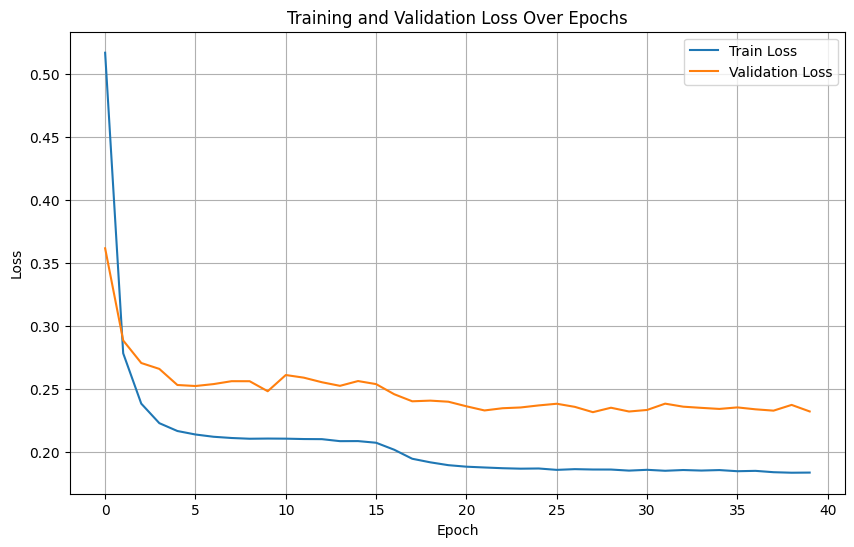

In [346]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [362]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.stats import spearmanr, pearsonr

class WordNet2Vec:
    def __init__(self, model: WordNetEmbeddingModel, word_to_id, id_to_word, device): 
        self.__devve = device
        self.__model = model
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word

    def get_vector(self, word: str):
        word_id = self.word_to_id.get(word, None)
        if word_id is None:
            raise Exception(f"word not found: {word}")
        tensor = torch.tensor([word_id]).to(self.__devve)
        emb = self.__model.input_embeddings(tensor)[0].reshape(1, -1).cpu().detach().numpy()
        return emb

    def calculate_similarity(self, word1: str, word2: str):
        emb1 = self.get_vector(word1)
        emb2 = self.get_vector(word2)

        similarity = cosine_similarity(emb1, emb2)[0][0]
        return similarity

    def predict(self, word:str, top_k: int = 5):
        embedding = self.get_vector(word)

        all_embeddings = self.__model.input_embeddings.weight.cpu().detach().numpy()

        similarities = cosine_similarity(embedding, all_embeddings).flatten()

        # Get the indices of the top k most similar words
        top_k_indices = np.argsort(similarities)[::-1][:top_k+1]  # Exclude the input word itself
    
        # Get the predicted words
        predicted_words = [self.id_to_word[idx] for idx in top_k_indices]
    
        return predicted_words

    def evaluate_word_similarity(self, dataset):
        similarities = []
        human_scores = []

        for word1, word2, human_score in dataset:
            if word1 in self.word_to_id and word2 in self.word_to_id:
                model_similarity = self.calculate_similarity(word1, word2)
                similarities.append(model_similarity)
                human_scores.append(human_score)

        spearman_corr, _ = spearmanr(similarities, human_scores)
        pearson_corr, _ = pearsonr(similarities, human_scores)
        return {"spearman": spearman_corr, "pearson": pearson_corr}

    def evaluate_word_analogies(self, analogy_dataset):
        correct = 0
        total = 0

        for w1, w2, w3, w4 in analogy_dataset:
            if all(word in self.word_to_id for word in [w1, w2, w3, w4]):
                predicted_words = self.predict(w3, top_k=10)
                if w4 in predicted_words:
                    correct += 1
                total += 1

        accuracy = correct / total if total > 0 else 0
        return accuracy

    

In [ ]:
# prompt: save the model in the project and google drive

import os

# Save the model to the project directory
model_save_path = 'wordnet_embedding_model_partial2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Save the model to Google Drive
drive_save_path = '/content/drive/MyDrive/wordnet_embedding_model_partial2.pth'  # Update with your desired path
torch.save(model.state_dict(), drive_save_path)
print(f"Model saved to Google Drive: {drive_save_path}")

Model saved to: wordnet_embedding_model_partial2.pth
Model saved to Google Drive: /content/drive/MyDrive/wordnet_embedding_model_partial2.pth


In [351]:
wn2vec = WordNet2Vec(model, word_to_id, id_to_word, device)



# Example usage
word1 = "sun"
word2 = "hot"
similarity = wn2vec.calculate_similarity(word1, word2)
print(f"Similarity between '{word1}' and '{word2}': {similarity}")

w1_emb = wn2vec.get_vector(word1)


predictions1 = wn2vec.predict(word1)
print(f"Predicted words: {predictions1}")
predictions2 = wn2vec.predict(word2)
print(f"Predicted words: {predictions2}")


Similarity between 'sun' and 'hot': -0.06679953634738922
Predicted words: ['sun', 'church_service', 'hulk', 'disbeliever', 'torpedo_boat', 'orifice']
Predicted words: ['hot', 'kyphosidae', 'epicalyx', 'bawdy', 'occupied', 'bas_relief']


In [355]:
simlex999_file = "SimLex-999.txt"
simlex999_ds = []

with open(simlex999_file, 'r') as file:
    _ = file.readline()
    for line in file.readlines():
        line_split = line.strip().split("\t")
        if len(line_split) >= 4:
            w1, w2, score = line_split[0], line_split[1], float(line_split[3])
            simlex999_ds.append((w1, w2, score))
        


In [358]:
ws353_file = "wordsim353_agreed.txt"
ws353_ds = []

with open(ws353_file, 'r') as file:
    _ = file.readline()
    for line in file.readlines():
        line_split = line.strip().split("\t")
        if len(line_split) >= 4:
            w1, w2, score = line_split[1], line_split[2], float(line_split[3])
            ws353_ds.append((w1, w2, score))

In [365]:
results = wn2vec.evaluate_word_similarity(ws353_ds)
print(f"Word Similarity - Spearman: {results['spearman']:.4f}, Pearson: {results['pearson']:.4f}")

Word Similarity - Spearman: 0.0597, Pearson: 0.0665


In [366]:
results1 = wn2vec.evaluate_word_similarity(simlex999_ds)
print(f"Word Similarity - Spearman: {results1['spearman']:.4f}, Pearson: {results1['pearson']:.4f}")

Word Similarity - Spearman: -0.0553, Pearson: -0.0680


In [367]:
import pickle

In [ ]:
synset_dataset_partial[:10]

[{'name': 'able.a.01',
  'lemmas': ['able'],
  'definition': "(usually followed by `to') having the necessary means or skill or know-how or authority to do something",
  'pos': 'a',
  'examples': ['able to swim',
   'she was able to program her computer',
   'we were at last able to buy a car',
   'able to get a grant for the project'],
  'definition_tokens': ['usually',
   'followed',
   'by',
   'to',
   'having',
   'the',
   'necessary',
   'mean',
   'or',
   'skill',
   'or',
   'or',
   'authority',
   'to',
   'do',
   'something']},
 {'name': 'unable.a.01',
  'lemmas': ['unable'],
  'definition': "(usually followed by `to') not having the necessary means or skill or know-how",
  'pos': 'a',
  'examples': ['unable to get to town without a car',
   'unable to obtain funds'],
  'definition_tokens': ['usually',
   'followed',
   'by',
   'to',
   'not',
   'having',
   'the',
   'necessary',
   'mean',
   'or',
   'skill',
   'or']},
 {'name': 'abaxial.a.01',
  'lemmas': ['abaxial

In [368]:
with open('words_to_id_sg.pkl', 'wb') as f:
    pickle.dump(word_to_id, f)


with open('id_to_word_sg.pkl', 'wb') as f:
    pickle.dump(id_to_word, f)